# Problem Statement

Since video streaming service like Netflix, Disney plus and HBO become more and more popular, many people spend more times on television show and movie, while some of them prefer television show over movie because tv shows has more complex story, more character, and more time to digest. Some people prefer movie over tv show because it takes less time, and it has more special effect. As a part of data science team at film and television production company, I was tasked with creating a model that will be able to take a reddit post and classify which posts were talking about movies and which posts were talking about TV show to find current trends so the company can decide to make movies or television show according to consumer demand.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
!pip install wordcloud
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords

from bs4 import BeautifulSoup
from nltk import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier

# Import Data

- Movie Suggestions
- Television Suggestions

In [2]:
movie_df = pd.read_csv('data/movie.csv')
tv_df = pd.read_csv('data/tv.csv')

# Exploratory Data Analysis

> **Movie Suggestions**

In [3]:
movie_df.head()

,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,link_flair_richtext,...,parent_whitelist_status,stickied,url,subreddit_subscribers,created_utc,num_crossposts,media,is_video,url_overridden_by_dest,author_cakeday
0,NaN,MovieSuggestions,# Rules\n1. [Be excellent with each other](htt...,t2_pnpz5,False,NaN,0,False,Using This Subreddit,[],...,all_ads,True,https://www.reddit.com/r/MovieSuggestions/comm...,213793,1.525910e+09,0,NaN,False,NaN,NaN
1,NaN,MovieSuggestions,I've taken all of the comments indicating grea...,t2_pnpz5,False,NaN,0,False,Top 100 - February 2021 is Up,[],...,all_ads,True,https://www.reddit.com/r/MovieSuggestions/comm...,213793,1.615321e+09,0,NaN,False,NaN,NaN
2,NaN,MovieSuggestions,I've been dealing with a lot of social anxiety...,t2_bs10y0y,False,NaN,0,False,Movies for people dealing with social anxiety ...,[],...,all_ads,False,https://www.reddit.com/r/MovieSuggestions/comm...,213793,1.615642e+09,0,NaN,False,NaN,NaN
3,NaN,MovieSuggestions,Hi!\n\nI'm looking for films about characters ...,t2_hhkbi,False,NaN,0,False,"Movies about the past, nostalgia and memories",[],...,all_ads,False,https://www.reddit.com/r/MovieSuggestions/comm...,213793,1.615688e+09,0,NaN,False,NaN,NaN
4,NaN,MovieSuggestions,Recently watched The Vast of Night and I reall...,t2_y8mwl,False,NaN,0,False,Looking for movies that feel like a feature le...,[],...,all_ads,False,https://www.reddit.com/r/MovieSuggestions/comm...,213793,1.615676e+09,0,NaN,False,NaN,NaN


In [4]:
# I will only use subreddit, title and selftext columns
movie_df = movie_df[['subreddit','title','selftext']]

In [5]:
movie_df.head()

,subreddit,title,selftext
0,MovieSuggestions,Using This Subreddit,# Rules\n1. [Be excellent with each other](htt...
1,MovieSuggestions,Top 100 - February 2021 is Up,I've taken all of the comments indicating grea...
2,MovieSuggestions,Movies for people dealing with social anxiety ...,I've been dealing with a lot of social anxiety...
3,MovieSuggestions,"Movies about the past, nostalgia and memories",Hi!\n\nI'm looking for films about characters ...
4,MovieSuggestions,Looking for movies that feel like a feature le...,Recently watched The Vast of Night and I reall...


In [6]:
# Look like row 0 it's just a suggestion post for this sub reddit so I decided to dropped it
movie_df.drop(0, inplace = True)

In [7]:
movie_df.head()

,subreddit,title,selftext
1,MovieSuggestions,Top 100 - February 2021 is Up,I've taken all of the comments indicating grea...
2,MovieSuggestions,Movies for people dealing with social anxiety ...,I've been dealing with a lot of social anxiety...
3,MovieSuggestions,"Movies about the past, nostalgia and memories",Hi!\n\nI'm looking for films about characters ...
4,MovieSuggestions,Looking for movies that feel like a feature le...,Recently watched The Vast of Night and I reall...
5,MovieSuggestions,Give me your favorite movie and i will rate it !,That's right give me your favorite movie and i...


In [8]:
# Create function to Look for duplicate posts
def duplicate_post(dataframe, column):
    duplicate_list = []
    for data, value in dataframe[column].value_counts().iteritems():
        if value > 1:
            duplicate_list.append(data)
        else:
            pass
    return duplicate_list

In [9]:
movie_dup_post = duplicate_post(movie_df, 'title')
movie_dup_post

['Need Movie Suggestion',
 '1989 movies to watch?',
 'Thrillers that are biblical allegories similar to Mother!, Jacob’s Ladder, The Devil’s Advocate?',
 'Mr Brooks (2007)',
 'Movies set in nature',
 'Movie About the History of Ireland',
 'Movies for people dealing with social anxiety and loneliness?',
 'New horrors 2021',
 'American nostalgia movies?',
 'similar to They Live ?',
 'Relationship between Younger and older partners',
 'Best Asian War Movie 2010 and Newer?',
 'Films I might have missed?',
 'Movies where the main character discovers they have super powers in a world where super powers are unknown?',
 'Movies about labor disputes/unions/strikes?',
 'Turkish Movies that made you cry',
 'Movies about friends growing apart',
 'I NEED A MOVIE',
 'Movies that present mindfulness/meditation important to work hard.',
 'Movies with really "slick" main characters?',
 'Movies that are so bad they’re good(or just really bad)',
 "Famous actor's most amazing underrated/overlooked films?"

In [10]:
# There are 749 posts that duplicates
len(movie_dup_post)

749

In [11]:
# So I decided to drop them
movie_df.drop_duplicates(subset = ['title'], inplace = True)

In [12]:
# No more duplicate row for title
duplicate_post(movie_df, 'title')

[]

In [13]:
# No duplicate row for selftext
duplicate_post(movie_df, 'selftext')

[]

In [14]:
# 4 null values for selftext column
movie_df.isnull().sum()

subreddit    0
title        0
selftext     4
dtype: int64

In [15]:
movie_df[movie_df['selftext'].isnull()]

,subreddit,title,selftext
236,MovieSuggestions,Just remembered Super (2010) and I'd like to r...,NaN
567,MovieSuggestions,Amadeus (1984),NaN
783,MovieSuggestions,TRON: Legacy (2010) - One of the best movie so...,NaN
831,MovieSuggestions,Mr. Nobody 2009-Best movie ever 11/10,NaN


Look like there are 4 posts that dont have selftext but they got title so I will create new column that combine title and selftext into one string.

In [16]:
# Fill nan with an empty string ('')
movie_df['selftext'].fillna('', inplace = True)

In [17]:
# No more null values
movie_df.isnull().sum()

subreddit    0
title        0
selftext     0
dtype: int64

In [18]:
movie_df['text'] = movie_df['title'] + movie_df['selftext']

In [19]:
movie_df.head()

,subreddit,title,selftext,text
1,MovieSuggestions,Top 100 - February 2021 is Up,I've taken all of the comments indicating grea...,Top 100 - February 2021 is UpI've taken all of...
2,MovieSuggestions,Movies for people dealing with social anxiety ...,I've been dealing with a lot of social anxiety...,Movies for people dealing with social anxiety ...
3,MovieSuggestions,"Movies about the past, nostalgia and memories",Hi!\n\nI'm looking for films about characters ...,"Movies about the past, nostalgia and memoriesH..."
4,MovieSuggestions,Looking for movies that feel like a feature le...,Recently watched The Vast of Night and I reall...,Looking for movies that feel like a feature le...
5,MovieSuggestions,Give me your favorite movie and i will rate it !,That's right give me your favorite movie and i...,Give me your favorite movie and i will rate it...


In [20]:
movie_df.shape

(860, 4)

Before clean the text I want to look for words that appear frequently in both subreddit so I create function that will count how often that word occurs and another function that will turn text into word cloud.

In [21]:
def count_words(text):
    count = {}
    word_list = []
    for row in text:
        word_list.extend(row.split())
    for word in word_list:
        if word in count.keys():
            count[word] += 1
        else:
            count[word] = 1
    
    count = pd.DataFrame(count.values(), columns = ['word'], index = count.keys())
    return count

In [22]:
movie_top_word = count_words(movie_df[movie_df['subreddit'] == 'MovieSuggestions']['text'])
movie_top_word

,word
Top,17
100,8
-,240
February,4
2021,5
...,...
Bruges'.,1
"track,",1
"budget,",1
"modest,",1


In [23]:
# Top 15 frequency word in movie suggestions
m_top10_word = movie_top_word.sort_values('word',ascending = False).head(15)
m_top10_word

,word
the,1777
and,1387
a,1323
of,1192
to,1130
I,1070
that,737
for,705
in,671
movies,662


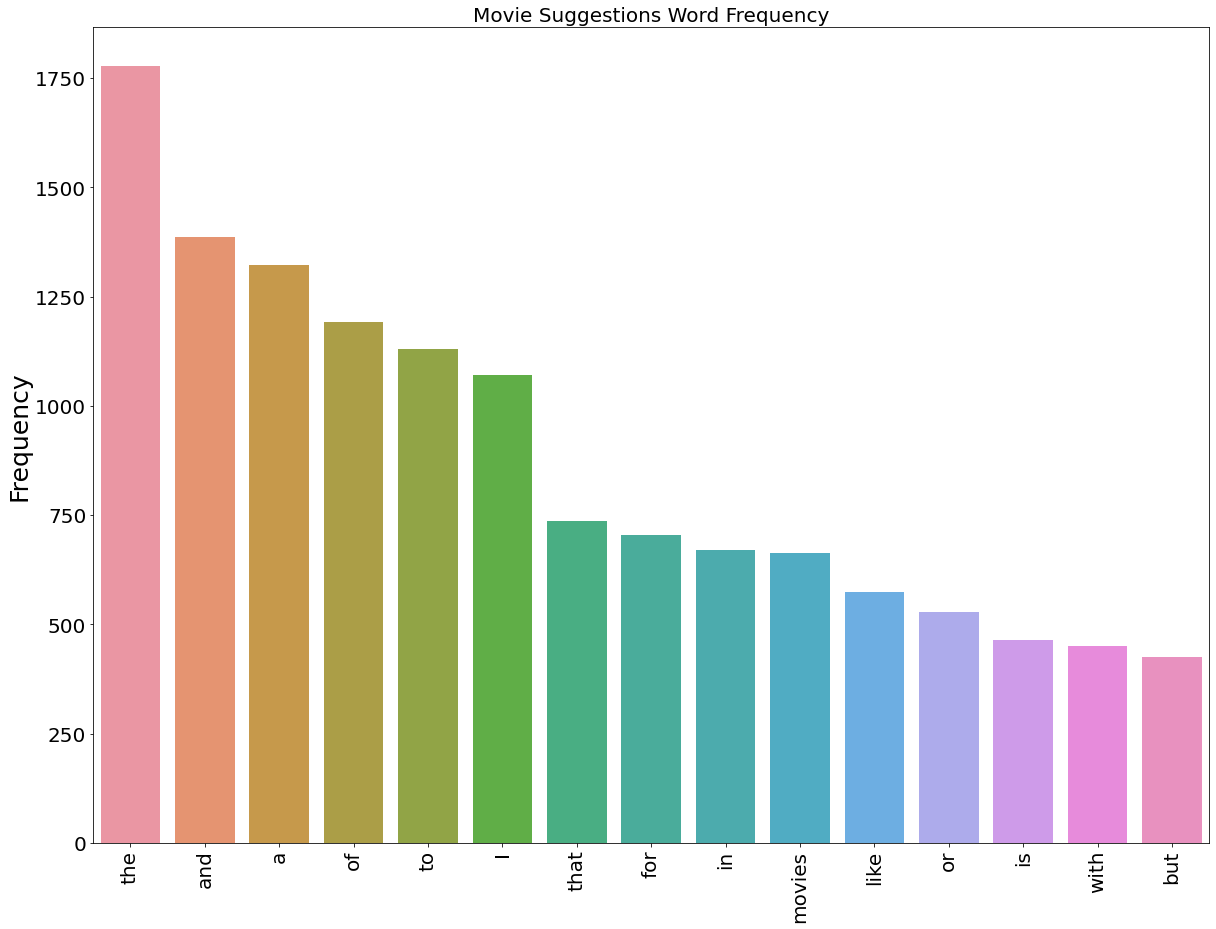

In [24]:
plt.figure(figsize = (20,15))
sns.barplot(x = m_top10_word.index, y = 'word',data = m_top10_word)
plt.xticks(fontsize = 20, rotation = 90)
plt.yticks(fontsize = 20)
plt.ylabel('Frequency', fontsize = 25)
plt.title('Movie Suggestions Word Frequency', fontsize  = 20)
plt.savefig("picture/m_bc_wf.png");

Look likes the top 15 word containing a lot of common words with no meaning like the, and, a, etc. So before doing the classification I will remove these words because they do not provide any information to the model.

In [25]:
def make_wordcloud(text):
    # Aggregate titles
    text = " ".join(title for title in text)
    # Instantiate Word Cloud
    wc = WordCloud(stopwords = stopwords.words('english'),  # exclude stop words
                          max_font_size=72,                 # control biggest font size
                          max_words=120,                    # set how many words will show up
                          background_color="white")         # fix background color
    # 'Fit' Word Cloud to text
    wordcloud = wc.generate(text)
    # Plot
    plt.figure(figsize=(12,12))
    plt.imshow(wordcloud, interpolation="bilinear");
    plt.axis("off");
    plt.show();

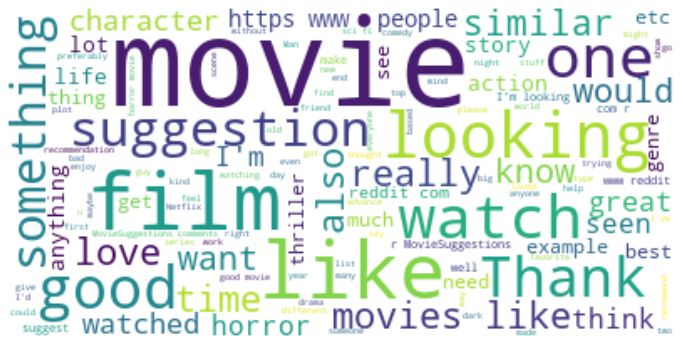

In [26]:
make_wordcloud(movie_df['text'])

> **Television Suggestions**

In [27]:
tv_df.head()

,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,link_flair_richtext,...,subreddit_subscribers,created_utc,num_crossposts,media,is_video,post_hint,preview,media_metadata,url_overridden_by_dest,author_cakeday
0,NaN,televisionsuggestions,I’ve recently found more time in my life again...,t2_3nfrqqnb,False,NaN,0,False,Suggest any show?,[],...,6478,1.615776e+09,0,NaN,False,NaN,NaN,NaN,NaN,NaN
1,NaN,televisionsuggestions,Doesnt necessarily have to be DC or superhero ...,t2_m0k3kk7,False,NaN,0,False,Other shows like HBO Max’s Harley Quinn animat...,[],...,6478,1.615780e+09,0,NaN,False,NaN,NaN,NaN,NaN,NaN
2,NaN,televisionsuggestions,"Hi looking for fantasy shows , I’ve seen GOT ,...",t2_9848s0w6,False,NaN,0,False,Fantasy shows,[],...,6478,1.615739e+09,0,NaN,False,NaN,NaN,NaN,NaN,NaN
3,NaN,televisionsuggestions,"Heya guys!\n\nSo, i am looking for something s...",t2_8yjbgnup,False,NaN,0,False,Something similar to The 100?,[],...,6478,1.615747e+09,0,NaN,False,NaN,NaN,NaN,NaN,NaN
4,NaN,televisionsuggestions,NaN,t2_5mutdzid,False,NaN,0,False,What are other series that can match the feel-...,[],...,6478,1.615706e+09,0,NaN,False,NaN,NaN,NaN,NaN,NaN


In [28]:
tv_df.columns

Index(['approved_at_utc', 'subreddit', 'selftext', 'author_fullname', 'saved',
       'mod_reason_title', 'gilded', 'clicked', 'title', 'link_flair_richtext',
       ...
       'subreddit_subscribers', 'created_utc', 'num_crossposts', 'media',
       'is_video', 'post_hint', 'preview', 'media_metadata',
       'url_overridden_by_dest', 'author_cakeday'],
      dtype='object', length=109)

In [29]:
# Select only columns that will use.
tv_df = tv_df[['subreddit','title','selftext']]

In [30]:
tv_df.head()

,subreddit,title,selftext
0,televisionsuggestions,Suggest any show?,I’ve recently found more time in my life again...
1,televisionsuggestions,Other shows like HBO Max’s Harley Quinn animat...,Doesnt necessarily have to be DC or superhero ...
2,televisionsuggestions,Fantasy shows,"Hi looking for fantasy shows , I’ve seen GOT ,..."
3,televisionsuggestions,Something similar to The 100?,"Heya guys!\n\nSo, i am looking for something s..."
4,televisionsuggestions,What are other series that can match the feel-...,NaN


In [31]:
# Look for duplicate rows or posts
tv_dup_post = duplicate_post(tv_df, 'title')
tv_dup_post

['Need a new show',
 'What should we watch next?',
 'Sopranos breaking bad game of thrones',
 'which is better acc to u;- F.R.I.E.N.D.S or the office ?',
 'Really good History series?',
 'Shows where main character discovers they have super powers in the world where super powers are unknown?',
 'Please help add to my watchlist...',
 'Drama series based on Human Emotions.',
 'Shows like Gilmore Girls, Buffy, Emily in Paris, Younger, The Bold Type etc?',
 "ABC's The Rookie worth watching?",
 'philosophical and funny plz',
 'Looking for something about a lonely person or someone who doesn’t have friends/ struggles to make friends',
 "What's he closest to Agents of SHIELD and Fringe you can recommend.",
 'Any shows about royal relationships?',
 'High fantasy, action heavy series to scratch that LOTR itch',
 "Shows That Aren't About Police/Murder",
 'Shows like gilmore girls or marvelous mrs maisel on amazon prime?',
 'Show with just 1 season and a few episodes, kind of like the feeling of 

In [32]:
# There are 625 duplicate rows for television suggestion
len(tv_dup_post)

625

In [33]:
# I decided to use drop duplicate to drop rows that duplicated
tv_df.drop_duplicates(subset = ['title'], inplace = True)

In [34]:
duplicate_post(tv_df, 'title')

[]

In [35]:
# Look like there is one more rows that duplicate for selftext columns
duplicate_post(tv_df, 'selftext')

["Share your favorite tv show that you just can't miss out on."]

In [36]:
tv_df[tv_df['selftext'] == "Share your favorite tv show that you just can't miss out on."]

,subreddit,title,selftext
227,televisionsuggestions,Shows you can't miss out on.,Share your favorite tv show that you just can'...
542,televisionsuggestions,Shows you can't miss out on,Share your favorite tv show that you just can'...


In [37]:
# So I decided to drop that row too
tv_df.drop(227, inplace = True)

In [38]:
duplicate_post(tv_df, 'selftext')

[]

In [39]:
# There are 92 missing values for selftext columns
tv_df.isnull().sum()

subreddit     0
title         0
selftext     92
dtype: int64

In [40]:
tv_df['selftext'].fillna('',inplace = True)

In [41]:
tv_df.isnull().sum()

subreddit    0
title        0
selftext     0
dtype: int64

In [42]:
tv_df['text'] = tv_df['title'] + tv_df['selftext']

In [43]:
tv_df

,subreddit,title,selftext,text
0,televisionsuggestions,Suggest any show?,I’ve recently found more time in my life again...,Suggest any show?I’ve recently found more time...
1,televisionsuggestions,Other shows like HBO Max’s Harley Quinn animat...,Doesnt necessarily have to be DC or superhero ...,Other shows like HBO Max’s Harley Quinn animat...
2,televisionsuggestions,Fantasy shows,"Hi looking for fantasy shows , I’ve seen GOT ,...","Fantasy showsHi looking for fantasy shows , I’..."
3,televisionsuggestions,Something similar to The 100?,"Heya guys!\n\nSo, i am looking for something s...","Something similar to The 100?Heya guys!\n\nSo,..."
4,televisionsuggestions,What are other series that can match the feel-...,,What are other series that can match the feel-...
...,...,...,...,...
994,televisionsuggestions,Show suggestions,So I just finished watching umbrella academy o...,Show suggestionsSo I just finished watching um...
995,televisionsuggestions,Police procedurals or legal drama with some hu...,"Hi, lately my younger brother and I have been ...",Police procedurals or legal drama with some hu...
996,televisionsuggestions,Show similar to botched or ambulance?,We love medical / surgical shows. We started a...,Show similar to botched or ambulance?We love m...
997,televisionsuggestions,Shows like Good Trouble?,I just finished Good Trouble on Hulu. It’s a s...,Shows like Good Trouble?I just finished Good T...


In [44]:
tv_df.shape

(996, 4)

In [45]:
tv_top_word = count_words(tv_df[tv_df['subreddit'] == 'televisionsuggestions']['text'])
tv_top10_word = tv_top_word.sort_values('word',ascending = False).head(15)
tv_top10_word

,word
the,1914
and,1718
I,1433
a,1353
of,1326
to,1251
for,825
that,754
The,741
like,729


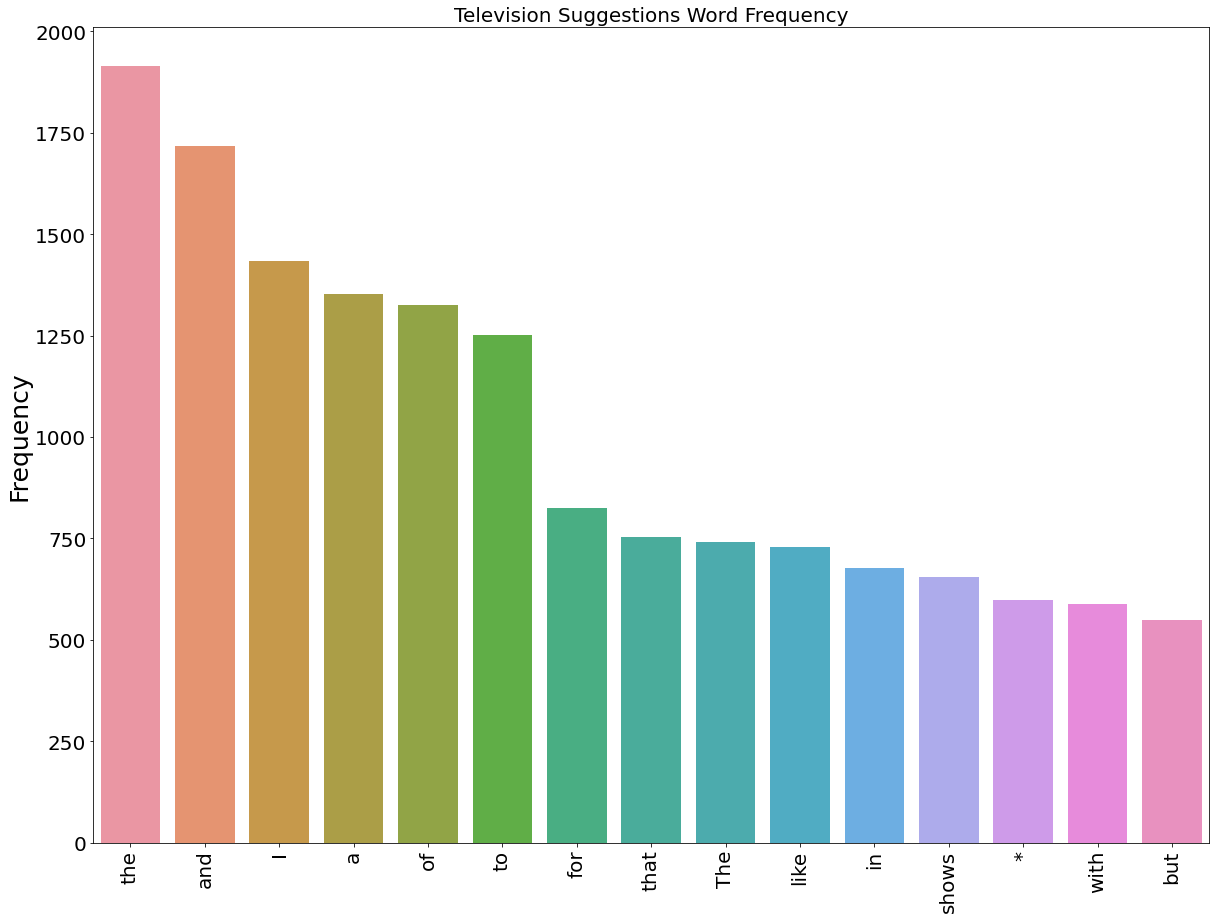

In [46]:
plt.figure(figsize = (20,15))
sns.barplot(x = tv_top10_word.index, y = 'word',data = tv_top10_word)
plt.xticks(fontsize = 20, rotation = 90)
plt.yticks(fontsize = 20)
plt.ylabel('Frequency', fontsize = 25)
plt.title('Television Suggestions Word Frequency', fontsize  = 20)
plt.savefig("picture/tv_bc_wf.png");

The result it's similar to movie suggestion but look like in tv data has some special character that appear frequently too like '*'.

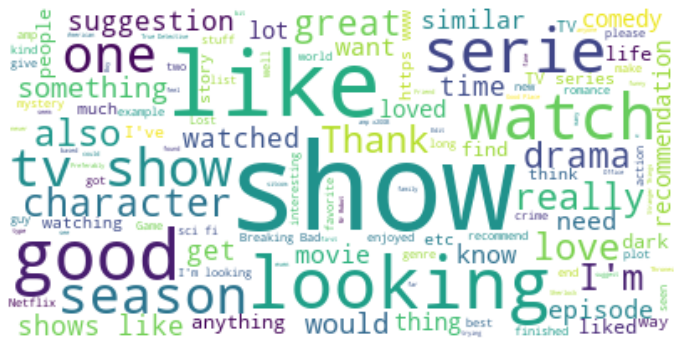

In [47]:
make_wordcloud(tv_df['text'])

> **Final Data**

Next, I will concatenate two dataframe into one data frame.

In [48]:
df_list = [movie_df, tv_df]
final_df = pd.concat(df_list)

In [49]:
final_df

,subreddit,title,selftext,text
1,MovieSuggestions,Top 100 - February 2021 is Up,I've taken all of the comments indicating grea...,Top 100 - February 2021 is UpI've taken all of...
2,MovieSuggestions,Movies for people dealing with social anxiety ...,I've been dealing with a lot of social anxiety...,Movies for people dealing with social anxiety ...
3,MovieSuggestions,"Movies about the past, nostalgia and memories",Hi!\n\nI'm looking for films about characters ...,"Movies about the past, nostalgia and memoriesH..."
4,MovieSuggestions,Looking for movies that feel like a feature le...,Recently watched The Vast of Night and I reall...,Looking for movies that feel like a feature le...
5,MovieSuggestions,Give me your favorite movie and i will rate it !,That's right give me your favorite movie and i...,Give me your favorite movie and i will rate it...
...,...,...,...,...
994,televisionsuggestions,Show suggestions,So I just finished watching umbrella academy o...,Show suggestionsSo I just finished watching um...
995,televisionsuggestions,Police procedurals or legal drama with some hu...,"Hi, lately my younger brother and I have been ...",Police procedurals or legal drama with some hu...
996,televisionsuggestions,Show similar to botched or ambulance?,We love medical / surgical shows. We started a...,Show similar to botched or ambulance?We love m...
997,televisionsuggestions,Shows like Good Trouble?,I just finished Good Trouble on Hulu. It’s a s...,Shows like Good Trouble?I just finished Good T...


After concatenate two dataframe look likes the index now is not in ordered yet, so I decided to reset the index first before cleaning the text.

In [50]:
final_df.reset_index(inplace = True)

In [51]:
# After reset index look likes there is one extra columns, so I decided to drop that column
final_df.head()

,index,subreddit,title,selftext,text
0,1,MovieSuggestions,Top 100 - February 2021 is Up,I've taken all of the comments indicating grea...,Top 100 - February 2021 is UpI've taken all of...
1,2,MovieSuggestions,Movies for people dealing with social anxiety ...,I've been dealing with a lot of social anxiety...,Movies for people dealing with social anxiety ...
2,3,MovieSuggestions,"Movies about the past, nostalgia and memories",Hi!\n\nI'm looking for films about characters ...,"Movies about the past, nostalgia and memoriesH..."
3,4,MovieSuggestions,Looking for movies that feel like a feature le...,Recently watched The Vast of Night and I reall...,Looking for movies that feel like a feature le...
4,5,MovieSuggestions,Give me your favorite movie and i will rate it !,That's right give me your favorite movie and i...,Give me your favorite movie and i will rate it...


In [52]:
final_df.drop(columns = ['index'], inplace = True)

In [53]:
final_df.head()

,subreddit,title,selftext,text
0,MovieSuggestions,Top 100 - February 2021 is Up,I've taken all of the comments indicating grea...,Top 100 - February 2021 is UpI've taken all of...
1,MovieSuggestions,Movies for people dealing with social anxiety ...,I've been dealing with a lot of social anxiety...,Movies for people dealing with social anxiety ...
2,MovieSuggestions,"Movies about the past, nostalgia and memories",Hi!\n\nI'm looking for films about characters ...,"Movies about the past, nostalgia and memoriesH..."
3,MovieSuggestions,Looking for movies that feel like a feature le...,Recently watched The Vast of Night and I reall...,Looking for movies that feel like a feature le...
4,MovieSuggestions,Give me your favorite movie and i will rate it !,That's right give me your favorite movie and i...,Give me your favorite movie and i will rate it...


In [54]:
final_df.shape

(1856, 4)

In [55]:
final_df.isnull().sum()

subreddit    0
title        0
selftext     0
text         0
dtype: int64

## Clean text

- After I got the final dataframe and cleaning all of the missing value, now I will eliminate special character, word that might make the model bias, some website url and stemming the text to use in classification.

In [56]:
def clean_text(raw_text):
    
    # Remove HTML 
    new_raw_text = BeautifulSoup(raw_text).get_text()
    
    # Remove non-letters
    letters_only = re.sub('[^a-zA-z]', ' ', new_raw_text)     # Remove non-letters
    letters_only = re.sub('https.*[c]om', ' ', letters_only)  # Remove https
    letters_only = re.sub('\[|\]', ' ', letters_only)     # Remove special characters
    letters_only = re.sub(r'\\|\^', ' ', letters_only)    # Remove special characters
    words = letters_only.lower().split()      # Split text in to a list of word
    
    # Remove stopwords
    stops = set(stopwords.words('english'))
    meaningful_word = [w for w in words if w not in stops]
    
    # Remove word that make bias
    remove_list = ['moviesuggestions','movie','movies','television','televisionsuggestions','tv','series','show', 'film']
    meaningful_word = [w for w in meaningful_word if w not in remove_list]
    
    # Stemming
    p_stemmer = PorterStemmer()
    stem_word = [p_stemmer.stem(w) for w in meaningful_word]
    new_word = ' '.join(stem_word)
    
    return new_word

In [57]:
# Try cleaning first row of text column
clean_text(final_df['text'][0])

'top februari upi taken comment indic great januari ment ad round thread end januari vote count next month climb climb onto top favourit harakiri bruge minari place beyond pine promis young woman solari fall fell top amadeu art self defens brigsbi bear blood tumbbad wind river name gain biggest gain la hain john wick readi top movement within top rank parasit upon time hollywood hereditari midsommar quiet place knive lighthous isl dog joker game night thought top fell climb anyth els'

In [58]:
# Try cleaning second row of text column
clean_text(final_df['text'][1])

'peopl deal social anxieti loneli deal lot social anxieti loneli life consid watch extent spare time right like watch someth help deal perhap someon deal automat thought etc learn go comfort zone situat improv somehow sort realist portray social anxieti form thank advanc'

In [59]:
# Cleaning all rows of text column
for i in range(final_df.shape[0]):
    final_df['text'][i] = clean_text(final_df['text'][i])

In [60]:
# Create target column (y) by select movie suggestion is a positive class and television suggestion as a negative class
final_df['y'] = final_df['subreddit'].map({'MovieSuggestions':1, 'televisionsuggestions':0})

In [61]:
# Check the distribution of two class
final_df['y'].value_counts(normalize = True)

0    0.536638
1    0.463362
Name: y, dtype: float64

In [62]:
final_df

,subreddit,title,selftext,text,y
0,MovieSuggestions,Top 100 - February 2021 is Up,I've taken all of the comments indicating grea...,top februari upi taken comment indic great jan...,1
1,MovieSuggestions,Movies for people dealing with social anxiety ...,I've been dealing with a lot of social anxiety...,peopl deal social anxieti loneli deal lot soci...,1
2,MovieSuggestions,"Movies about the past, nostalgia and memories",Hi!\n\nI'm looking for films about characters ...,past nostalgia memorieshi look film charact no...,1
3,MovieSuggestions,Looking for movies that feel like a feature le...,Recently watched The Vast of Night and I reall...,look feel like featur length twilight zone rec...,1
4,MovieSuggestions,Give me your favorite movie and i will rate it !,That's right give me your favorite movie and i...,give favorit rate right give favorit rate matt...,1
...,...,...,...,...,...
1851,televisionsuggestions,Show suggestions,So I just finished watching umbrella academy o...,suggestionsso finish watch umbrella academi ne...,0
1852,televisionsuggestions,Police procedurals or legal drama with some hu...,"Hi, lately my younger brother and I have been ...",polic procedur legal drama humor hi late young...,0
1853,televisionsuggestions,Show similar to botched or ambulance?,We love medical / surgical shows. We started a...,similar botch ambul love medic surgic show sta...,0
1854,televisionsuggestions,Shows like Good Trouble?,I just finished Good Trouble on Hulu. It’s a s...,show like good troubl finish good troubl hulu ...,0


After cleaning all the text, I want to check if the frequently words are different from the ones before cleaning.

In [63]:
movie_top_word = count_words(final_df[final_df['y'] == 1]['text'])
movie_top_word

,word
top,35
februari,3
upi,1
taken,6
comment,5
...,...
fallout,1
extract,1
calibr,1
prayer,1


In [64]:
# Top 10 frequency word in movie suggestions
m_top10_word = movie_top_word.sort_values('word',ascending = False).head(15)
m_top10_word

,word
like,680
watch,481
look,363
good,296
suggest,254
film,252
one,223
love,218
thank,208
realli,207


In [65]:
tv_top_word = count_words(final_df[final_df['y'] == 0]['text'])
tv_top10_word = tv_top_word.sort_values('word',ascending = False).head(15)
tv_top10_word

,word
show,975
like,949
watch,661
look,417
good,389
love,355
someth,319
realli,274
season,261
charact,259


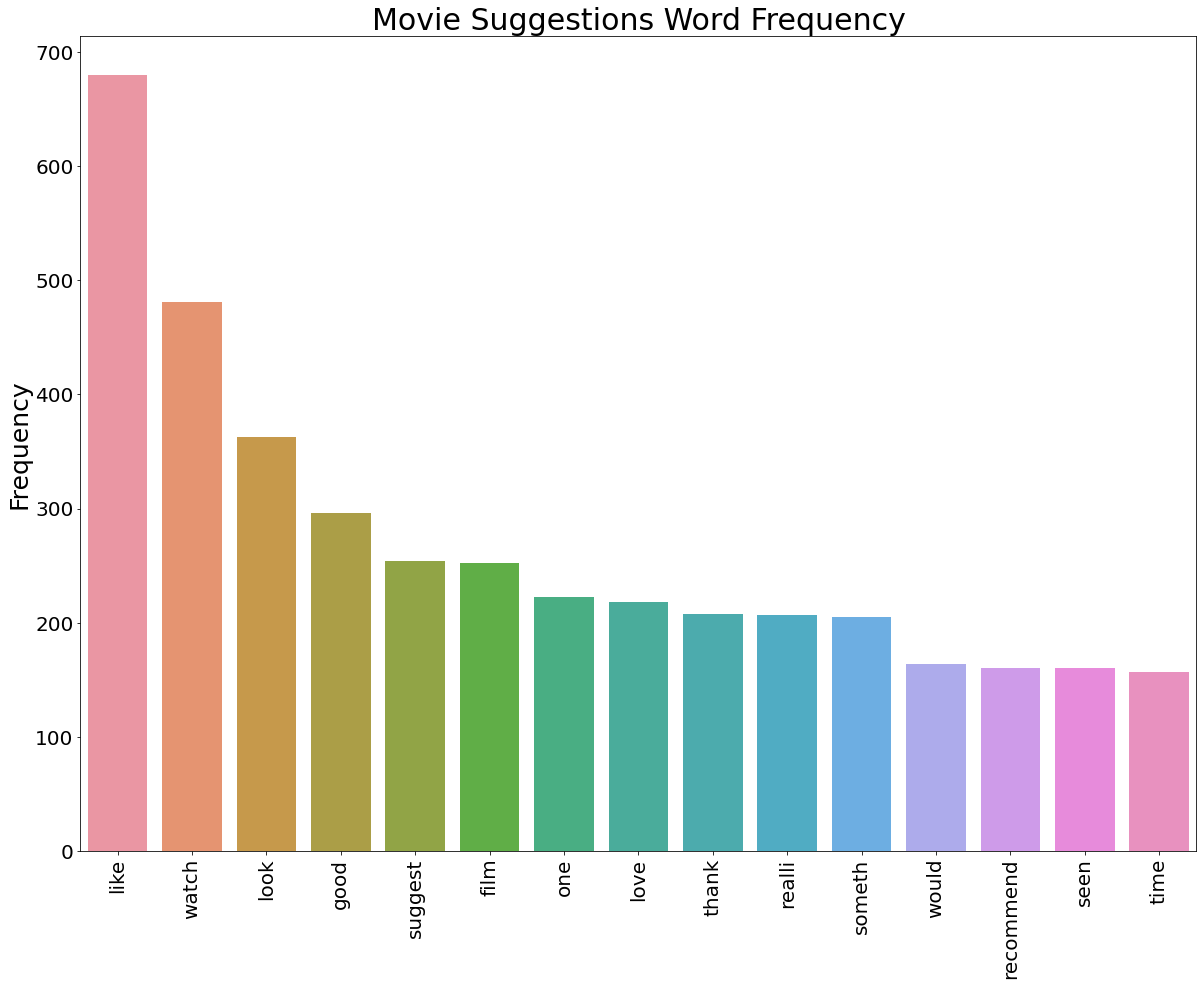

In [66]:
plt.figure(figsize = (20,15))
sns.barplot(x = m_top10_word.index, y = 'word',data = m_top10_word)
plt.xticks(fontsize = 20, rotation = 90)
plt.yticks(fontsize = 20)
plt.ylabel('Frequency', fontsize = 25)
plt.title('Movie Suggestions Word Frequency', fontsize  = 30)
plt.savefig("picture/m_ac_wf.png");

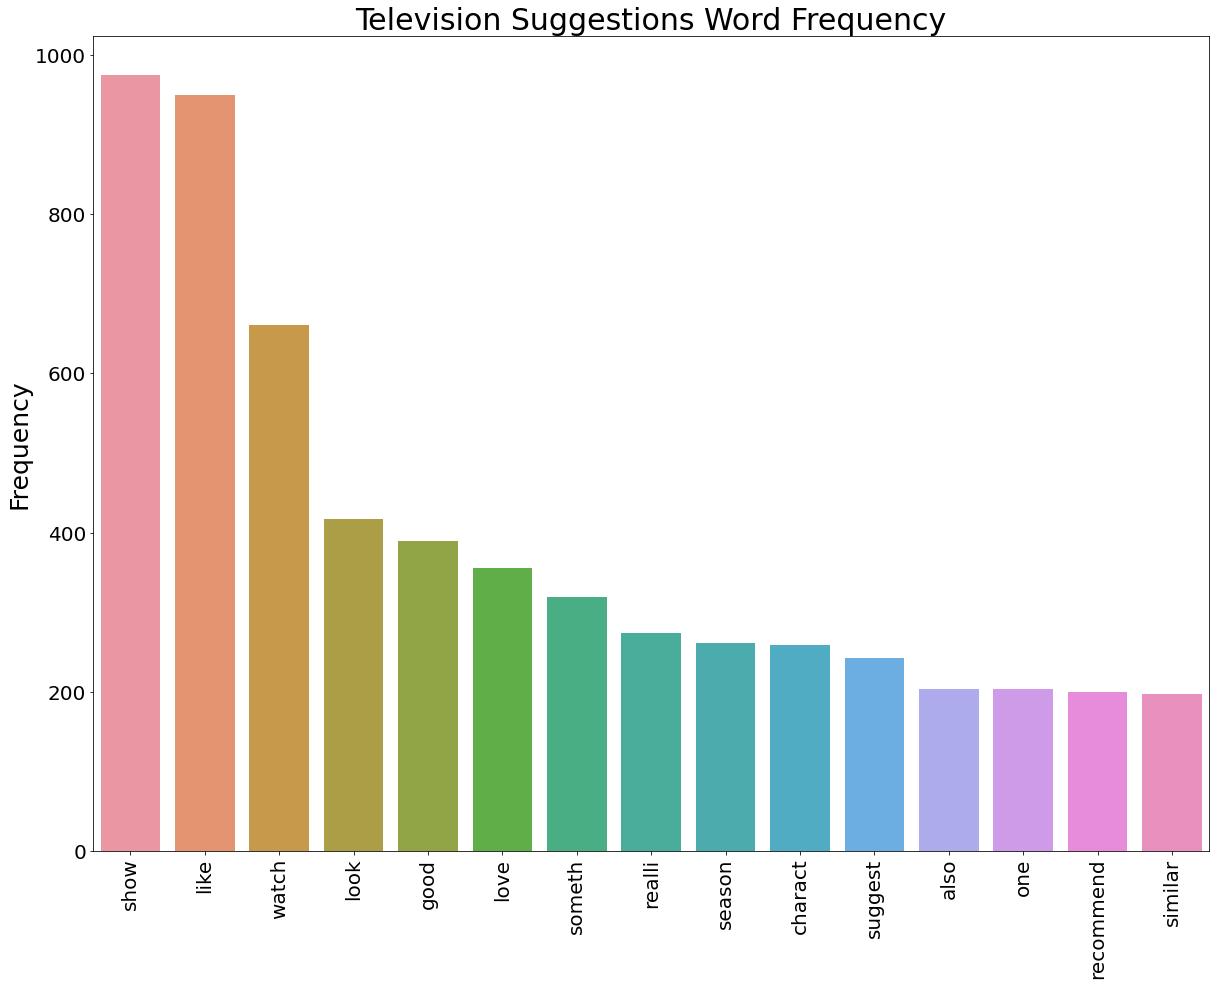

In [67]:
plt.figure(figsize = (20,15))
sns.barplot(x = tv_top10_word.index, y = 'word',data = tv_top10_word)
plt.xticks(fontsize = 20, rotation = 90)
plt.yticks(fontsize = 20)
plt.ylabel('Frequency', fontsize = 25)
plt.title('Television Suggestions Word Frequency', fontsize  = 30)
plt.savefig("picture/tv_ac_wf.png");

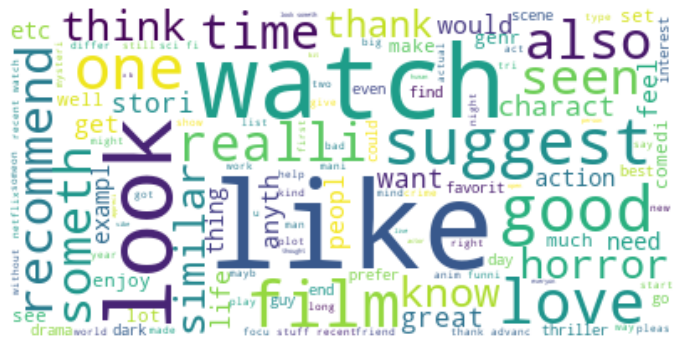

In [68]:
make_wordcloud(final_df[final_df['y'] == 1]['text'])

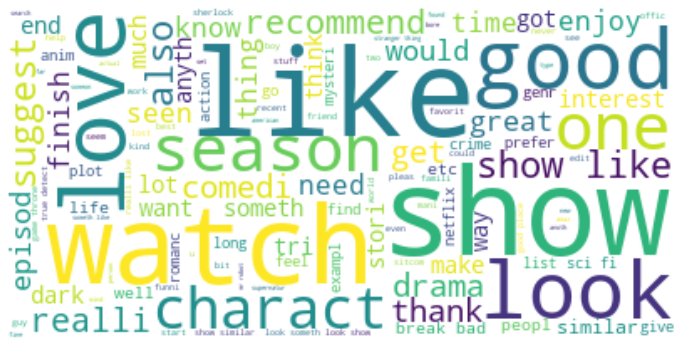

In [69]:
make_wordcloud(final_df[final_df['y'] == 0]['text'])

In [70]:
final_df.shape

(1856, 5)

# Model

In [71]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

I will use three model in this project which are logistic regression, multinomial naive bayes and support vector machine, so I created a function that will show the score of train, validation and test for each model.

In [72]:
def model_score(model, X_train, X_test, y_train, y_test):
    if model == 'LogisticRegression':
        lr = LogisticRegression()
        lr.fit(X_train, y_train)
        train_score = lr.score(X_train, y_train)
        validation_score = cross_val_score(lr, X_train, y_train, cv = 5).mean()
        test_score = lr.score(X_test, y_test)
    
    elif model == 'MultinomialNB':
        nb = MultinomialNB()
        nb.fit(X_train, y_train)
        train_score = nb.score(X_train, y_train)
        validation_score = cross_val_score(nb, X_train, y_train, cv = 5).mean()
        test_score = nb.score(X_test, y_test)
    

    elif model == 'SVC':
        svc = SVC()
        svc.fit(X_train,y_train)
        train_score = svc.score(X_train, y_train)
        validation_score = cross_val_score(svc, X_train, y_train, cv = 5).mean()
        test_score = svc.score(X_test, y_test)

        
    print(f'Train Accuracy Rate       = {train_score} \nValidation Accuracy Rate  = {validation_score} \nTest Accuracy Rate        = {test_score}')

In [73]:
X = final_df['text']
y = final_df['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

In [74]:
X_train.shape

(1392,)

In [75]:
X_test.shape

(464,)

In [76]:
# Baseline accuracy
y_train.value_counts(normalize = True)

0    0.536638
1    0.463362
Name: y, dtype: float64

In [77]:
# Baseline accuracy
y_test.value_counts(normalize = True)

0    0.536638
1    0.463362
Name: y, dtype: float64

## Text Feature Extraction

* Right now the feature that we will use in classification model is still in form of string which cannot be used by machine learning models, so I will transform it into numeric first by using count vectorizer.

In [78]:
cvec = CountVectorizer()
cvec.fit(X_train)
X_train = cvec.transform(X_train)
X_test = cvec.transform(X_test)

In [79]:
X_train

<1392x6494 sparse matrix of type '<class 'numpy.int64'>'
	with 40806 stored elements in Compressed Sparse Row format>

In [80]:
X_train.shape

(1392, 6494)

In [81]:
X_test.shape

(464, 6494)

In [82]:
pd.DataFrame(X_train.toarray(), columns = cvec.get_feature_names())

,_and,_nomin,_su,aaranya,aback,abandon,abbey,abbi,abc,aberr,...,zest,zim,zindagi,zlook,zodiac,zoey,zombi,zombieland,zone,zoo
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1387,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1388,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1389,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1390,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [83]:
X_train.shape

(1392, 6494)

## Logistic Regression

In [84]:
model_score('LogisticRegression', X_train, X_test, y_train, y_test)

Train Accuracy Rate       = 0.9985632183908046 
Validation Accuracy Rate  = 0.8240091797529718 
Test Accuracy Rate        = 0.8211206896551724


We can see that in training data set logistic regression model has highly accuracy rate at 99% or we can say that logistic regression model can distinguish which posts are movie suggestions, which are TV suggestions with accuracy rate at 99% for training data. But if we look at accuracy rate in validation set and test set we can see that it is around 82% which represent that this model is overfitting.

## Naive Bayes

In [85]:
model_score('MultinomialNB', X_train, X_test, y_train, y_test)

Train Accuracy Rate       = 0.9662356321839081 
Validation Accuracy Rate  = 0.8548722312472602 
Test Accuracy Rate        = 0.8383620689655172


For multionomial naive bayes model accuracy rate for training data is 96% while validation is 85% and test data is 83%. The result is similar to logistic regression model which is overfitting but it seems like naive bayes is less overfitting when compared to logistic regression.

## Support Vector Machine

In [86]:
model_score('SVC', X_train, X_test, y_train, y_test)

Train Accuracy Rate       = 0.9612068965517241 
Validation Accuracy Rate  = 0.8369304556354915 
Test Accuracy Rate        = 0.8512931034482759


The last model is support vector machine, the accuracy rate for training data is 96%, validation is 83% and for test data is 85%. This model is still overfitting but it's less ovefit than logistic regression and multinomial naive bayes.

From the results of three model we can see that now every model is overfitting, so I will do a grid search to find best hyper parameters to use in the model.

# Grid Search

In [87]:
def grid_search_score(model):
   
    # Assign variable and split in to train and test set
    X = final_df['text']
    y = final_df['y']
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)
    
    # Assign model to use in pipeline
    if model == 'LogisticRegression':
        model_use = LogisticRegression()
    elif model == 'MultinomialNB':
        model_use = MultinomialNB()
    elif model == 'SVC':
        model_use = SVC()
    
    # Pipeline
    pipe = Pipeline([
        ('cvec',CountVectorizer()),
        ('estimator', model_use)
    ])
    pipe.fit(X_train, y_train)
    
    # Create parameter to use in grid search
    if model == 'LogisticRegression':
        pipe_params = {
            'cvec__max_features': [1_000,2_000, 3_000, 4_000, 5_000],
            'cvec__max_df': [.9, .95],
            'cvec__ngram_range': [(1,1), (1,2)],
            'estimator__C':[0.01, 0.1, 1, 10]
        }
    
    elif model == 'MultinomialNB':
        pipe_params = {
            'cvec__max_features': [1_000,2_000, 3_000, 4_000, 5_000],
            'cvec__max_df': [.9, .95],
            'cvec__ngram_range': [(1,1), (1,2)],
            'estimator__alpha':[0.01, 0.1, 1, 10]
        }
    
    elif model == 'SVC':
        pipe_params = {
            'cvec__max_features': [ 1_000, 2_000, 3_000, 4_000, 5_000],
            'cvec__max_df': [.9, .95],
            'cvec__ngram_range': [(1,1), (1,2)],
            'estimator__C':[1,2,10,0.1],
            'estimator__gamma': ['scale',1, 0.1, 0.01],
        }
    
    # Grid search
    gs = GridSearchCV(pipe, param_grid = pipe_params, cv = 3)
    gs.fit(X_train, y_train)
    
    # Accuracy rate
    train_score = gs.score(X_train, y_train)
    test_score = gs.score(X_test, y_test)
    best_params = gs.best_params_
    best_score = gs.best_score_
    print(f'Train Accuracy Rate = {train_score} \nTest Accuracy Rate  = {test_score} \nBest Score          = {best_score} \nBest Params         = {best_params} ')
        

> **Logistic Regression**

In [88]:
grid_search_score('LogisticRegression')

Train Accuracy Rate = 0.9640804597701149 
Test Accuracy Rate  = 0.8362068965517241 
Best Score          = 0.8354885057471265 
Best Params         = {'cvec__max_df': 0.9, 'cvec__max_features': 5000, 'cvec__ngram_range': (1, 2), 'estimator__C': 0.1} 


After doing a grid search on logistic regression accuracy rate on train data is decreasing from 99% to 96% while test data is increasing from 82% to 84%.  This model it's still overfitting but it's less than the one that we didn't do grid search.

> **Multinomial Naive Bayes**

In [89]:
grid_search_score('MultinomialNB')

Train Accuracy Rate = 0.9425287356321839 
Test Accuracy Rate  = 0.8577586206896551 
Best Score          = 0.8599137931034483 
Best Params         = {'cvec__max_df': 0.9, 'cvec__max_features': 3000, 'cvec__ngram_range': (1, 2), 'estimator__alpha': 1} 


After doing grid search on multinomial naive bayes accuracy rate on train data is decreasing from 96% to 94% while on test data accuracy rate increasing from 83% to 86%. This model it's still overfitting but it's less than the one that we didn't do grid search.

> **Support Vector Machine**

In [90]:
grid_search_score('SVC')

Train Accuracy Rate = 0.959051724137931 
Test Accuracy Rate  = 0.8556034482758621 
Best Score          = 0.8390804597701149 
Best Params         = {'cvec__max_df': 0.9, 'cvec__max_features': 3000, 'cvec__ngram_range': (1, 2), 'estimator__C': 2, 'estimator__gamma': 0.01} 


After doing grid search on support vector machine accuracy on train data is decreased 1% while on test data accuracy rate remains at 85%.

From the results of three model after doing grid search it turns out that multinomial naive bayes is the best predictor model in this project because it's got the highest accuracy rate on test data and less overfitting than logistic regression and support vector machine.

### Create best prediction model

In [91]:
X = final_df['text']
y = final_df['y']
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state = 42, stratify = y)

In [92]:
cvec = CountVectorizer(max_df = 0.9, max_features = 3000, ngram_range = (1,2))
cvec.fit(X_train, y_train)
X_train = cvec.transform(X_train)
X_test = cvec.transform(X_test)

In [93]:
X_train.shape

(1392, 3000)

In [94]:
X_test.shape

(464, 3000)

In [95]:
nb = MultinomialNB(alpha = 1)
nb.fit(X_train, y_train)
print(f'Train Accuracy Rate = {nb.score(X_train, y_train)} \nTest Accuracy Rate  = {nb.score(X_test, y_test)}')

Train Accuracy Rate = 0.9425287356321839 
Test Accuracy Rate  = 0.8577586206896551


# Confusion Matrix

In [96]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, plot_roc_curve

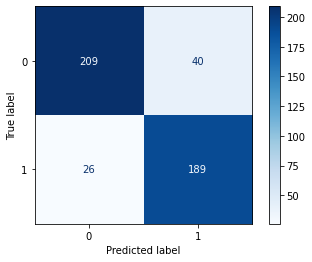

In [97]:
plot_confusion_matrix(nb, X_test, y_test, cmap = 'Blues');

From the confusion matrix graph we can see that this model is correctly predicted that 189 posts are movie suggestions and 209 posts are television suggestions while false predicted that 26 posts are movie suggestions and 40 posts are television suggestions.

In [98]:
tn, fp, fn, tp = confusion_matrix(y_test, nb.predict(X_test)).ravel()
print(f'True Positive: {tp} \nTrue Negative: {tn} \nFalse Positive: {fp} \nFalse Negative: {fn}')

True Positive: 189 
True Negative: 209 
False Positive: 40 
False Negative: 26


- True Positive means that we are correctly preidcted that this post is movie suggestions, this model correctly predicted that 189 posts are movie suggestions.

- True Negative means that we are correctly predicted that this post is television suggestions, this model correctly predicted that 209 posts are television suggestions.

- False Positive means that we are false predicted that this post is movie suggestions but actually it is television suggestions, this model false predicted 40 posts are movie suggestions.

- False Negative means that we are false predicted that this post is television suggestions but actually it is movie suggestions, this model false predicted 26 posts are television suggestions.

In [99]:
accuracy = (tp + tn)/(tp+fp+tn+fn)
misclassification = 1 - accuracy
sensitivity = tp/(tp + fn)
specificity = tn/(tn + fp)
precision = tp/(tp+fp)
print(f'Accuracy = {round(accuracy,2)} \nMisclassification Rate = {round(misclassification,2)} \nSensitivity = {round(sensitivity,2)} \nSpecificity = {round(specificity,2)} \nPrecision = {round(precision, 2)}')

Accuracy = 0.86 
Misclassification Rate = 0.14 
Sensitivity = 0.88 
Specificity = 0.84 
Precision = 0.83


- Accuracy is the percentage of obsercations that correctly predicted, this model has accuracy rate at 86%.

- Misclassification rate is the percentage of observations that incorrectly predicted, this model has misclassification rate at 14 %

- Sensitivity or True positive rate is the percentage that we correctly predicted that this post is movie suggestions compared to all movie suggestion post, this model has true positive rate at 88%.

- Specificity or True negative rate is the percentage that we correctly predicted that this post is television suggestions compared to all television suggestion post, this model has true negative rate at 84%.

- Precision or Positive predictive value is the percentage that we correctly predicted that this post is movie suggestion when compared to all prediction that this post will be movie suggestion, this model has precision rate at 83%.


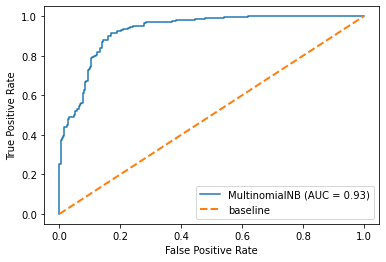

In [100]:
plot_roc_curve(nb, X_test, y_test)
plt.plot([0,1],[0,1], lw=2, linestyle='--', label = 'baseline')
plt.legend();

This graph is roc curve it shows the trade-off between true positive rate and false positive rate, blue line is the line of multinomial naive bayes while orange line is baseline model. The closer to baseline model means that the model has less accurate on test data and the farther from baseline model means that the model has more accuracy on test data. The area under curve or AUC it is equivalent to the probability that a randomly chosen positive instance is ranked higher than a randomly chosen negative instance which has value between 0.5 to 1, the closer to 1 means that positive and negative populations are greatly separated. This model has AUC equal to 0.93 which means that this model doing good on separated positive and negative populations.

# Top Word

In [101]:
nb.feature_log_prob_

array([[ -8.76776512,  -8.76776512,  -8.58544357, ..., -10.37720303,
         -8.17997846,  -8.76776512],
       [-10.08037772,  -9.38723054,  -8.28861825, ...,  -7.77779263,
         -7.37232752,  -8.28861825]])

In [102]:
nb.feature_log_prob_[0]

array([ -8.76776512,  -8.76776512,  -8.58544357, ..., -10.37720303,
        -8.17997846,  -8.76776512])

In [103]:
nb.feature_log_prob_[0][::-1]

array([ -8.76776512,  -8.17997846, -10.37720303, ...,  -8.58544357,
        -8.76776512,  -8.76776512])

In [104]:
nb.feature_log_prob_[0].argsort() # argsort will return the indice of data

array([ 345, 1675, 1671, ..., 2841, 1422, 2313], dtype=int32)

In [105]:
nb.feature_log_prob_[0].argsort()[::-1] # [::-1] will reverse the index, the last one will be the first one and first one will be the last one.

array([2313, 1422, 2841, ..., 1671, 1675,  345], dtype=int32)

In [106]:
tv_prob_sorted = nb.feature_log_prob_[0, :].argsort()[::-1]
movie_prob_sorted = nb.feature_log_prob_[1, :].argsort()[::-1]
tv_top_word = np.take(cvec.get_feature_names(), tv_prob_sorted[:10]) # np.take will take elements from an array along an axis.
movie_top_word = np.take(cvec.get_feature_names(), movie_prob_sorted[:10])

print(tv_top_word)
print(movie_top_word)

['show' 'like' 'watch' 'look' 'good' 'love' 'someth' 'realli' 'charact'
 'season']
['like' 'watch' 'look' 'good' 'suggest' 'film' 'love' 'realli' 'one'
 'someth']


# Conclusion and Recommendation

**Conclusion**

Based on the train and test accuracy, it appears that multinomial naive bayes performed the best out of three. With train accuracy rate at 94% and test accuracy rate at 85%, multinomial naive bayes also has less overfit when compared to logistic regression and support vector machine. On unseen data this model correctly predicted that 189 posts are movie suggestion and 209 posts are television suggestion. The top 10 words that use to classificaty for movie and television are overlapping such as 'like', 'watch','look','good' and 'realli'.
        

**Recommendation**

- This project use only 3 models (Logistic regression, Multinomial naive bayes and Support vector machine) maybe try another classification model.

- Try another feature extraction like Tfidf vectorizer or hashing vectorizer

- Try remove some words that frequently appear in both data.
        